Let's see what the pipeline will look like.

# 1. Get some cutouts

In [1]:
from lensedquasarsutilities.model_PSF_from_field import download_and_extract, estimate_psf_from_extracted_h5

workdir = '/tmp/test'
ra, dec = 320.6075, -16.357

savepath_fits, savepath_cutouts_h5 = download_and_extract(ra, dec, workdir, survey='legacysurvey')
savepath_fits, savepath_cutouts_h5

1.10.1


(PosixPath('/tmp/test/cutouts_legacysurvey_J2122-1621.fits'),
 PosixPath('/tmp/test/cutouts_legacysurvey_J2122-1621_cutouts.h5'))

The above 
- queried Gaia to know what field size is necessary to have at least one star that can be used to model the PSF in the field. 
- downloaded all the files available in the specified survey in a fits file.
- extracted cutouts of the stars that can be used for PSF, and of the lens, preserving the WCS information.

# 2. Get a pixelated PSF model with STARRED

In [2]:
estimate_psf_from_extracted_h5(savepath_cutouts_h5)

The above added the narrow PSF to the hdf5 file already containing the cutouts. We can use it to model the lensed quasar.

# 3. (work in progress) Model the lensed quasar

Start by getting an initial guess for the positions of the lensed images with Gaia:

In [3]:
from lensedquasarsutilities.gaia_utilities import find_gaia_stars_around_coords

r = find_gaia_stars_around_coords(ra, dec, 5)
ra1, dec1 = r[0]['ra'], r[0]['dec']
ra2, dec2 = r[1]['ra'], r[1]['dec']
(ra1, dec1), (ra2, dec2)

INFO: Query finished. [astroquery.utils.tap.core]


((320.6073887222918, -16.356898198379383),
 (320.607629964023, -16.357139399185396))

Next, let's get the cutout of the lens, say in the z-band, and the PSF.

In [4]:
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel

from lensedquasarsutilities.io import load_dict_from_hdf5

data = load_dict_from_hdf5(savepath_cutouts_h5)

lens = data['lens']['z']['0']['data']
noise = data['lens']['z']['0']['noise']
wcs_header = str(data['lens']['z']['0']['wcs_header'], encoding='ascii')
wcs = WCS(wcs_header)

psf = data['z']['0']['psf']

Ok, simple model with 2 PSFs and one sersic (very rigid for now)

(-0.5, 30.5, -0.5, 30.5)

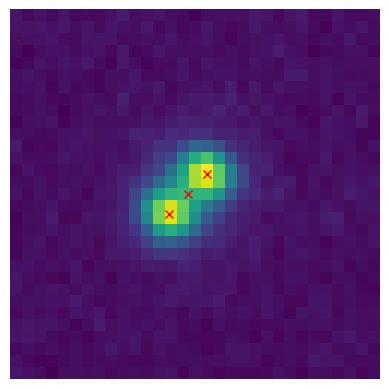

In [5]:
from lensedquasarsutilities.image_fitting import SimpleLensedQuasarModel

model = SimpleLensedQuasarModel(lens[0], noise[0], psf, upsampling_factor=2)

# ok, initial guess, galaxy between the two images:
rag = 0.5 * (ra1 + ra2)
decg = 0.5 * (dec1 + dec2)

# let's transform the coordinates to our pixel array
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs.utils import skycoord_to_pixel

im1 = SkyCoord(ra1*u.deg, dec1*u.deg)
im2 = SkyCoord(ra2*u.deg, dec2*u.deg)
g = SkyCoord(rag*u.deg, decg*u.deg)

x1, y1 = skycoord_to_pixel(im1, wcs)
x2, y2 = skycoord_to_pixel(im2, wcs)
xg, yg = skycoord_to_pixel(g, wcs)

import matplotlib.pyplot as plt
plt.imshow(lens[0], origin='lower')
plt.plot([x1, x2, xg], [y1, y2, yg], 'x', color='red')
plt.axis('off')

Messy part: transform from image coordinate to model coordinate.
The origin is at the center of the image, not in the corner, and we are at a higher resolution,
hence the "subsampling_factor" factor.

In [6]:
sf = subsampling_factor = 2
offset = (sf*lens.shape[1] - 1) / 2.
# do it for every coordinate ...messy, to be hidden.
x1, y1, x2, y2, xg, yg = sf*x1-offset, sf*y1-offset, sf*x2-offset, sf*y2-offset, sf*xg-offset, sf*yg-offset

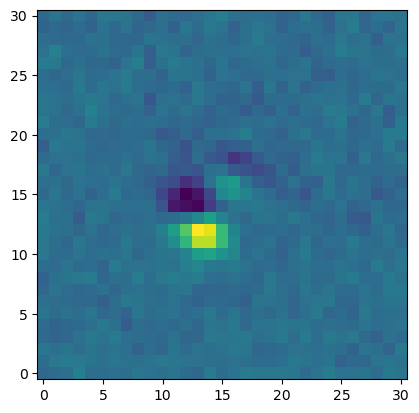

In [7]:
#                x1, y1, A1,  x2, y2, A2,  xg, yg, I_e,  r_e,  n,  ellip, theta
initial_guess = [x1, y1, 100, y2, x2, 100., xg, yg, 0.0001, 2., 2.5, 0.1, 0.]
residuals = model.residuals_with_galaxy(initial_guess)
plt.imshow(residuals.reshape(lens[0].shape), origin='lower')

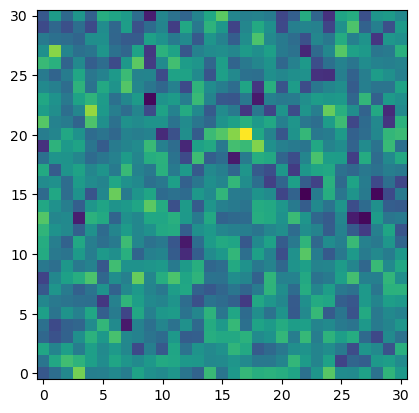

In [8]:
params = model.optimize_with_galaxy(initial_guess)
residuals = model.residuals_with_galaxy(params)
plt.imshow(residuals.reshape(lens[0].shape), origin='lower')

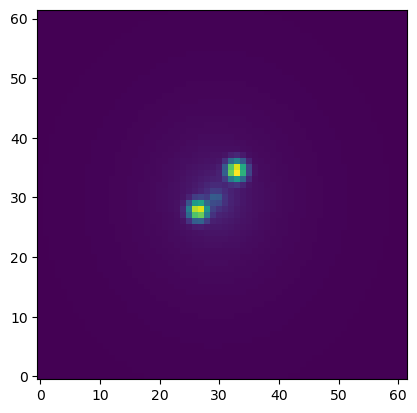

In [9]:
plt.imshow(model.create_model_with_galaxy(*params)**0.5, origin='lower')

suspicious galaxy, let's try sampling.

In [10]:
samples = model.sample_with_galaxy(initial_guess, num_warmup=100, num_samples=200)

sample: 100%|█| 300/300 [03:53<00:00,  1.29it/s, 875 steps of size 3.15e-03. acc



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        A1     97.07      0.94     97.05     95.37     98.42    141.33      1.03
        A2     95.41      0.38     95.31     95.00     95.98     86.48      1.00
       I_e      0.00      0.00      0.00      0.00      0.00    243.17      1.00
     ellip      0.12      0.09      0.10      0.01      0.24    171.76      1.00
         n      8.56      1.12      8.93      6.94      9.96     99.76      1.00
       r_e     18.73      1.09     19.06     16.92     19.97    122.76      1.00
     theta      3.10      1.97      3.22      0.02      5.70    134.02      1.00
        x1      1.78      0.04      1.78      1.72      1.85    123.17      1.00
        x2     -4.27      0.05     -4.27     -4.35     -4.19    172.72      1.01
        xg      2.41      0.65      2.41      1.79      3.27     17.29      1.30
        y1      3.35      0.04      3.35      3.28      3.41    164.29      1.00
        y2     -3.09      0

In [11]:
import arviz as az

inf_data = az.from_numpyro(samples)
az.summary(inf_data)

arviz - WARNING - Shape validation failed: input_shape: (1, 200), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
A1,97.066,0.941,95.367,98.776,0.097,0.069,90.0,109.0,NaN
A2,95.412,0.382,95.002,96.133,0.041,0.029,54.0,48.0,NaN
I_e,0.001,0.000,0.001,0.001,0.000,0.000,213.0,119.0,NaN
ellip,0.116,0.088,0.004,0.272,0.007,0.005,160.0,154.0,NaN
n,8.557,1.122,6.264,9.991,0.109,0.079,94.0,117.0,NaN
r_e,18.725,1.092,16.454,19.950,0.097,0.069,129.0,179.0,NaN
theta,3.100,1.974,0.019,6.048,0.166,0.124,108.0,35.0,NaN
x1,1.780,0.043,1.690,1.856,0.004,0.003,124.0,132.0,NaN
x2,-4.271,0.050,-4.352,-4.177,0.004,0.003,170.0,185.0,NaN
xg,2.409,0.651,1.370,3.257,0.382,0.345,4.0,95.0,NaN


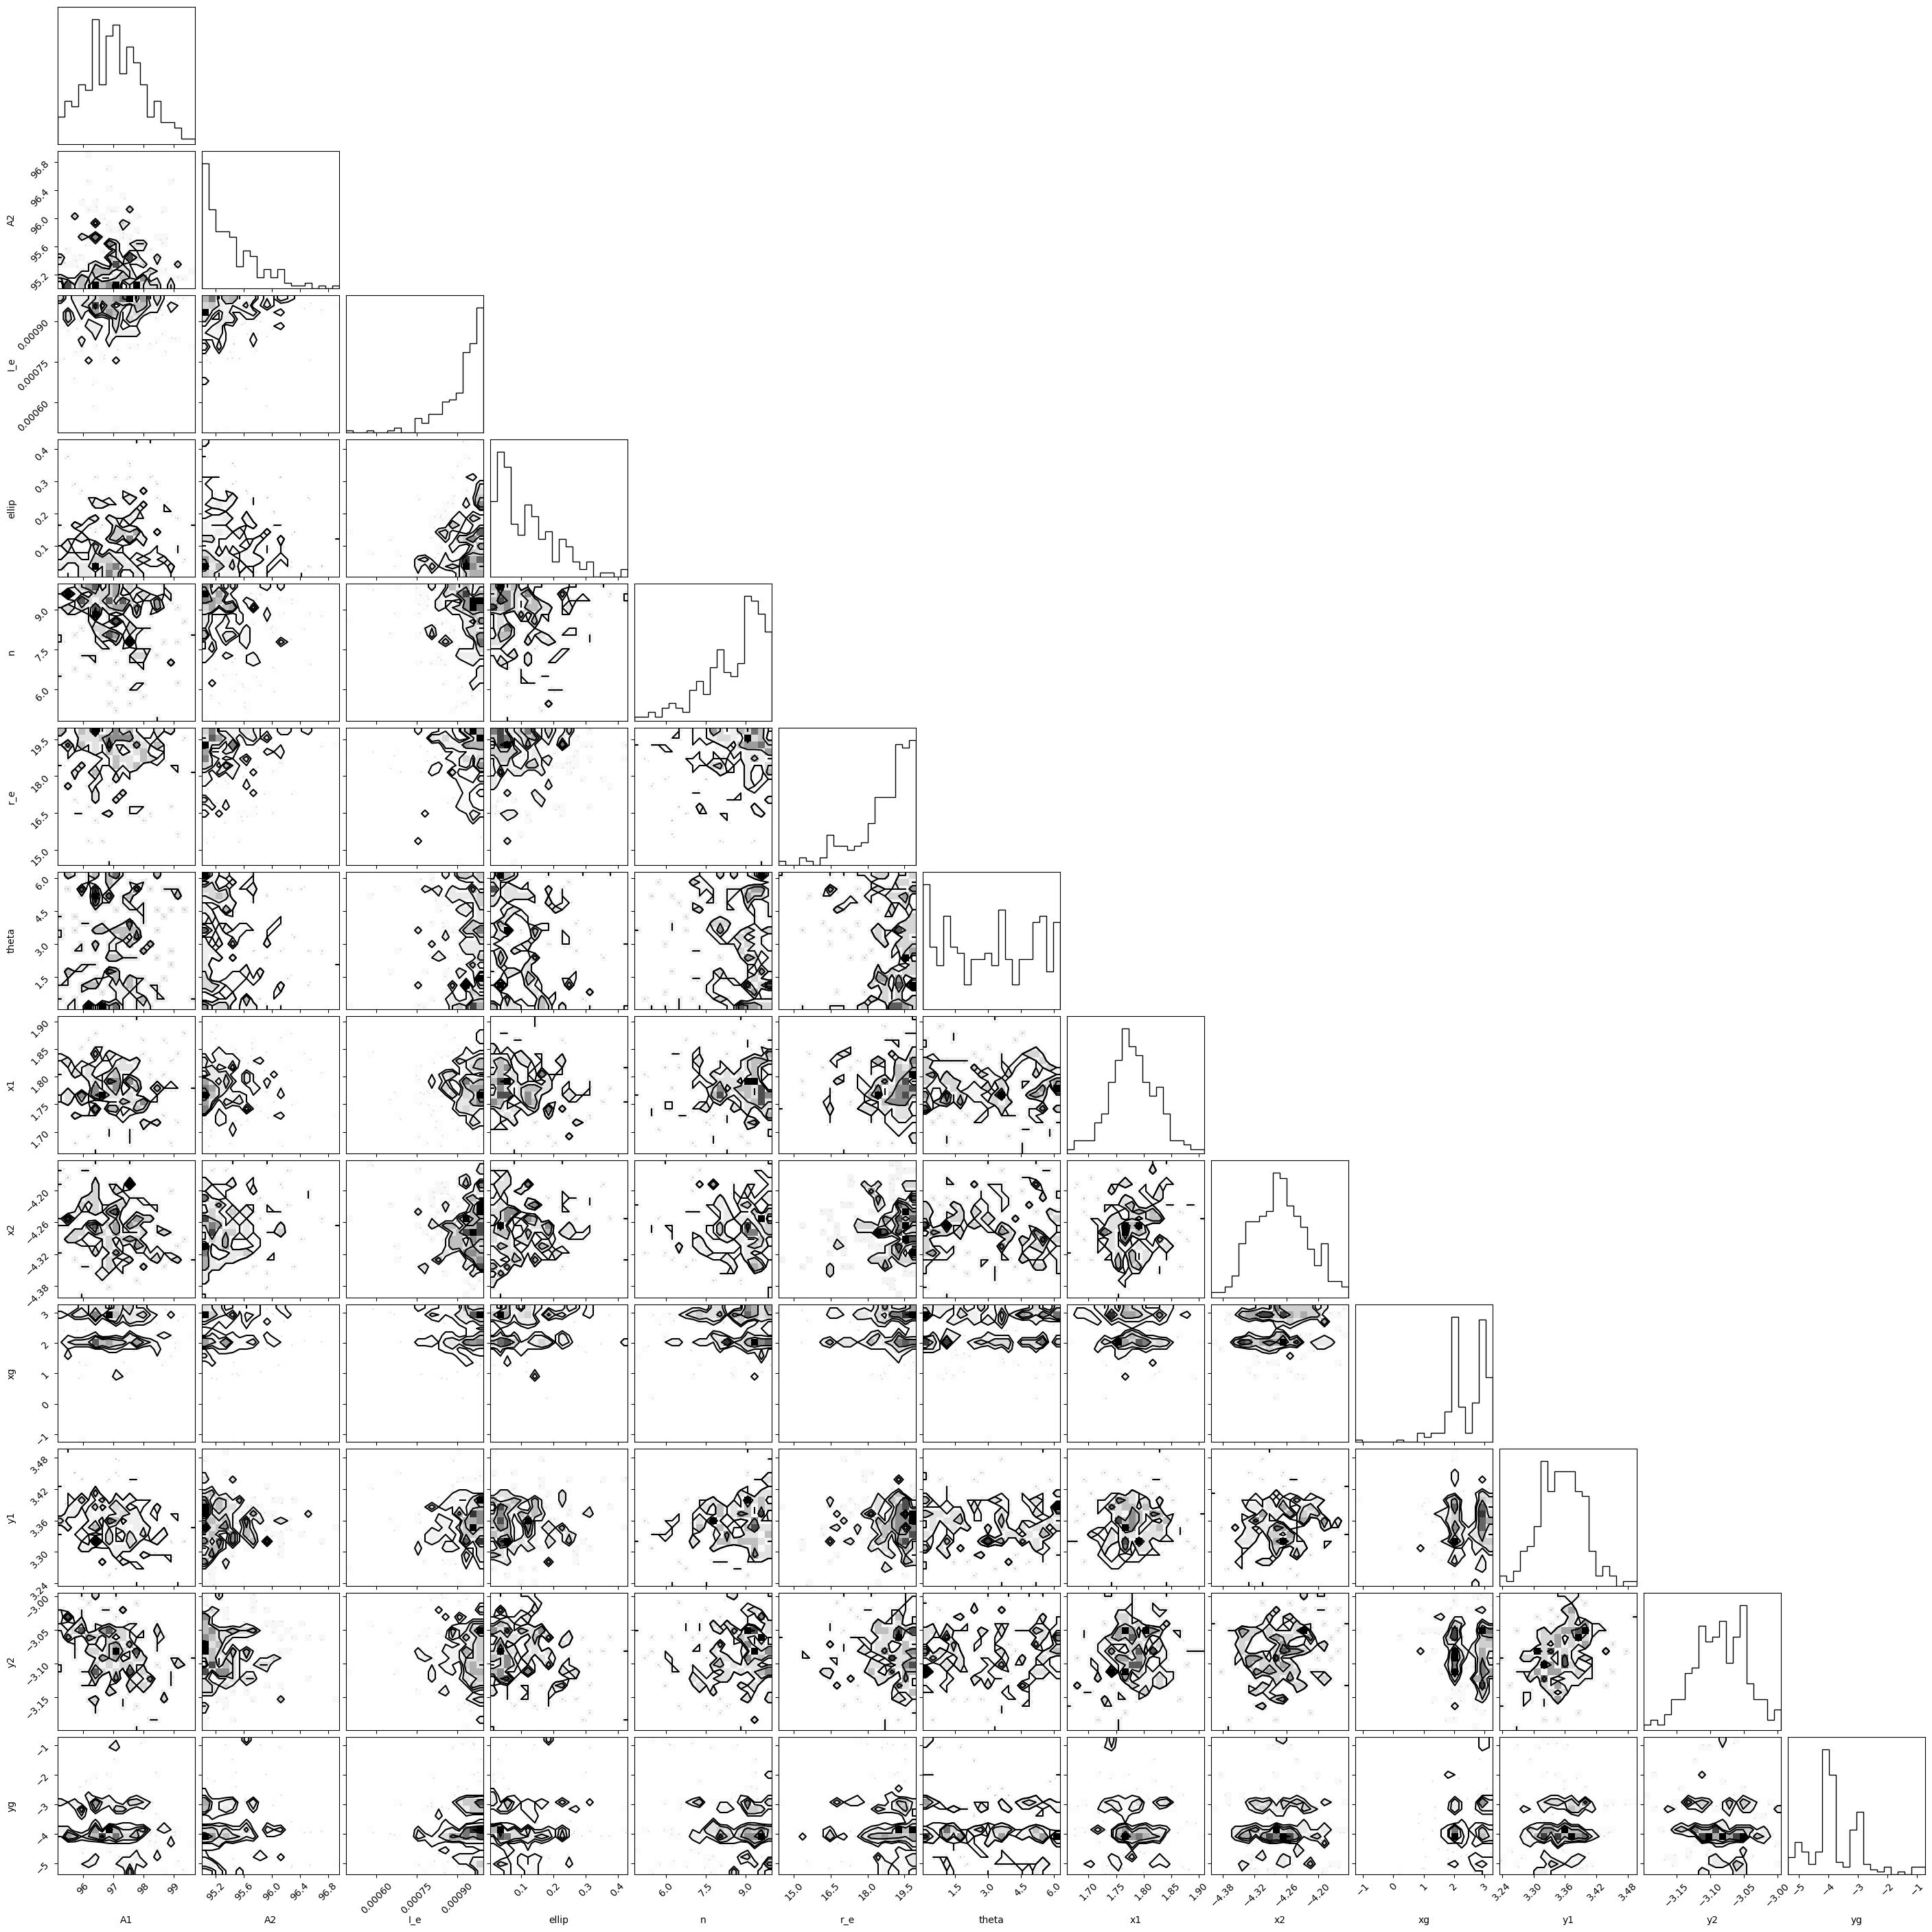

In [13]:
from corner import corner
corner(inf_data);